In [1]:
!nvidia-smi

Fri Nov  6 09:55:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transforms3d
!pip install keras-tcn

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, spatial, stats
from fastdtw import fastdtw
from scipy.signal import find_peaks
import pywt
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
from keras.layers import Input, Dense, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.models import Model
from sklearn.preprocessing import OneHotEncoder
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from keras.metrics import Accuracy, Precision, Recall
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tcn import TCN, tcn_full_summary

Using TensorFlow backend.


In [4]:
os.chdir('gdrive/My Drive/Weave/Earables Project/Final Experiments/')

In [7]:
from densenet.classifiers.one_d import DenseNet121

In [5]:
data = pickle.load(open('data/processed_df.pkl', 'rb'))
fold_idx = pickle.load(open('data/5_fold_idx.pkl', 'rb'))

In [6]:
test_fold_i = 3
train_idx, test_idx =[], []
for i, idx in enumerate(fold_idx):
    if i == test_fold_i:
        test_idx.append(idx)
    else:
        train_idx.append(idx)
train_idx = np.concatenate(train_idx)
test_idx = np.concatenate(test_idx)
print('train: {}, test: {}'.format(len(train_idx), len(test_idx)))
X_train = data.loc[train_idx].iloc[:,:-3].to_numpy()
y_train = data.loc[train_idx].iloc[:,-3:-2]
X_test = data.loc[test_idx].iloc[:,:-3].to_numpy()
y_test = data.loc[test_idx].iloc[:,-3:-2]
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train).toarray()
y_test = ohe.transform(y_test).toarray()

train: 14984, test: 3746


In [7]:
n_classes = y_train.shape[1]
print('num. of classes: {}'.format(n_classes))

num. of classes: 32


In [8]:
class Data_Generator(keras.utils.Sequence):
    
    def __init__(self, data_x, labels, batch_size) :
        self.data_x = data_x
        self.labels = labels
        self.batch_size = batch_size
    
    def __len__(self):
        return (np.ceil(len(self.data_x) / float(self.batch_size))).astype(np.int)
  
    def __getitem__(self, idx) :
        x = self.data_x[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        batch_x = np.ones((x.shape[0], 100, x.shape[1]))

        for i in range(len(x)):
            # aug = np.random.choice(range(4))
            aug = 3
            #print(aug)
            temp = np.array([np.array(a) for a in x[i]])
            if aug == 0:
                batch_x[i] = np.hstack([self.DA_TimeWarp(temp[3*j:3*(j+1)].T) for j in range(len(temp)//3)])
            elif aug == 1:
                batch_x[i] = np.hstack([self.DA_MagWarp(temp[3*j:3*(j+1)].T, 0.2) for j in range(len(temp)//3)])
            elif aug == 2:
                batch_x[i] = np.hstack([self.DA_Rotation(temp[3*j:3*(j+1)].T) for j in range(len(temp)//3)])
            else:
                batch_x[i] = temp.T

        return np.array(batch_x), np.array(batch_y)

    def DistortTimesteps(self, X, sigma=0.2):
        tt = self.GenerateRandomCurves(X, sigma) # Regard these samples aroun 1 as time intervals
        tt_cum = np.cumsum(tt, axis=0)        # Add intervals to make a cumulative graph
        # Make the last value to have X.shape[0]
        t_scale = [(X.shape[0]-1)/tt_cum[-1,0],(X.shape[0]-1)/tt_cum[-1,1],(X.shape[0]-1)/tt_cum[-1,2]]
        tt_cum[:,0] = tt_cum[:,0]*t_scale[0]
        tt_cum[:,1] = tt_cum[:,1]*t_scale[1]
        tt_cum[:,2] = tt_cum[:,2]*t_scale[2]
        return tt_cum

    def DA_TimeWarp(self, X, sigma=0.2):
        tt_new = self.DistortTimesteps(X, sigma)
        X_new = np.zeros(X.shape)
        x_range = np.arange(X.shape[0])
        X_new[:,0] = np.interp(x_range, tt_new[:,0], X[:,0])
        X_new[:,1] = np.interp(x_range, tt_new[:,1], X[:,1])
        X_new[:,2] = np.interp(x_range, tt_new[:,2], X[:,2])
        return X_new

    def DA_Rotation(self, X):
        axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
        angle = np.random.uniform(low=-np.pi, high=np.pi)
        return np.matmul(X , axangle2mat(axis,angle))

    def GenerateRandomCurves(self, X, sigma=0.2, knot=4):
        xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
        yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
        x_range = np.arange(X.shape[0])
        cs_x = CubicSpline(xx[:,0], yy[:,0])
        cs_y = CubicSpline(xx[:,1], yy[:,1])
        cs_z = CubicSpline(xx[:,2], yy[:,2])
        return np.array([cs_x(x_range),cs_y(x_range),cs_z(x_range)]).transpose()
    
    def DA_MagWarp(self, X, sigma):
        return X * self.GenerateRandomCurves(X, sigma)

In [14]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

batch_size = 32
input_shape = (100, 12)
img_input = Input(shape=(100, 12))

x = TCN(return_sequences=True)(img_input)
x = TCN(return_sequences=False, nb_filters=128)(x)
# x = Dropout(rate=0.2)(x)
x = Dense(n_classes, activation='sigmoid', name='output')(x)

model = Model(img_input, x, name='tcn2_12ch')
model.summary()

Model: "tcn_12ch"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100, 12)]         0         
_________________________________________________________________
tcn_9 (TCN)                  (None, 100, 64)           93248     
_________________________________________________________________
tcn_10 (TCN)                 (None, 128)               386688    
_________________________________________________________________
output (Dense)               (None, 32)                4128      
Total params: 484,064
Trainable params: 484,064
Non-trainable params: 0
_________________________________________________________________


In [15]:
batch_size = 32
train_gen = Data_Generator(X_train, y_train, batch_size)
test_gen = Data_Generator(X_test, y_test, batch_size)

In [19]:
model_name = 'tcn2_sigmoid_f3'
optimizer = Adam(learning_rate=0.0001)
# loss = BinaryCrossentropy()
model.load_weights('checkpoint/{}.h5'.format(model_name))
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='accuracy')
checkpoint = ModelCheckpoint('checkpoint/{}.h5'.format(model_name), monitor='val_loss', verbose=1, mode='min',save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=0.000001)

In [17]:
tmp = []
for i in range(len(X_train)):
    ch = []
    for j in range(12):
        ch.append(X_train[i][j])
    ch = np.array(ch).T
    tmp.append(ch)
X_train = np.array(tmp)

tmp = []
for i in range(len(X_test)):
    ch = []
    for j in range(12):
        ch.append(X_test[i][j])
    ch = np.array(ch).T
    tmp.append(ch)
X_test = np.array(tmp)
del tmp, ch
print(X_train.shape)
print(X_test.shape)

(74918, 100, 12)
(18730, 100, 12)


In [20]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    epochs=100,
                    # workers=4,
                    callbacks=[checkpoint, earlystopping, reducelr],
                    shuffle=True)

Epoch 1/100
2342/2342 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9694
Epoch 00001: val_loss improved from inf to 0.03227, saving model to checkpoint/tcn2_sigmoid_f3.h5
2342/2342 [==============================] - 42s 18ms/step - loss: 0.0069 - accuracy: 0.9694 - val_loss: 0.0323 - val_accuracy: 0.8847
Epoch 2/100
2341/2342 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 0.9865
Epoch 00002: val_loss did not improve from 0.03227
2342/2342 [==============================] - 40s 17ms/step - loss: 0.0034 - accuracy: 0.9865 - val_loss: 0.0335 - val_accuracy: 0.8899
Epoch 3/100
2340/2342 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9913
Epoch 00003: val_loss did not improve from 0.03227
2342/2342 [==============================] - 40s 17ms/step - loss: 0.0024 - accuracy: 0.9913 - val_loss: 0.0348 - val_accuracy: 0.8945
Epoch 4/100
2341/2342 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9939

In [22]:
pred = model.predict(X_test)

In [35]:
ohe.categories_[0][1]

'10'

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       375
           1       0.87      0.90      0.89       640
           2       0.89      0.90      0.90       450
           3       0.88      0.89      0.89       670
           4       0.93      0.91      0.92       625
           5       0.87      0.85      0.86       610
           6       0.92      0.90      0.91       640
           7       0.86      0.89      0.88       570
           8       0.92      0.90      0.91       605
           9       0.91      0.90      0.90       675
          10       0.91      0.92      0.92       640
          11       0.88      0.87      0.88       615
          12       0.91      0.90      0.91       675
          13       0.84      0.87      0.85       590
          14       0.91      0.89      0.90       685
          15       0.82      0.86      0.84       605
          16       0.90      0.93      0.92       570
          17       0.89    

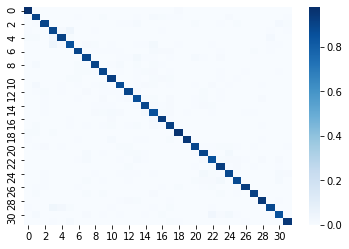

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = [np.argmax(p) for p in pred]
y_true = [np.argmax(p) for p in y_test]
cf_mat = confusion_matrix(y_true, y_pred, normalize='true')
print(classification_report(y_true, y_pred))
sns.heatmap(cf_mat, cmap='Blues')

In [37]:
pickle.dump(cf_mat, open('tcn1_all_confusion_matrix.pkl', 'wb'))